In [1]:
import matplotlib.pyplot as plt
import numpy as np
# mongoclient#
import pymongo
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import plotly.express as px
import plotly.graph_objects as go
from scipy import signal
from collections import defaultdict

In [2]:
def obtain_data(nome_exp: str, client: MongoClient) -> dict:
    db = client['experiments']
    collection = db[nome_exp]
    cursor = collection.find()
    data = defaultdict(list)
    for x in cursor:
        try:
            samples = x["samples"]
            for sample in samples:
                if sample["status"] == 1:
                    data[sample["sensorLabel"]].append((x["index"], sample["value"]))
        except:
            print(x)

    return data



In [3]:
name_exp_noEXO = 'Exp_prova_christian_good_btsData'
exp_noEXO_data = dict()
# name_exp_EXO = 'Exp_2024-04-15T12_45_39_932Z_BtsData'
# exp_EXO_data = dict()


In [4]:
mGClient = MongoClient(f'mongodb://10.250.4.35:27017') 
exp_noEXO_data["raw_data"] = obtain_data(name_exp_noEXO, mGClient)
# exp_EXO_data["raw_data"] = obtain_data(name_exp_EXO, mGClient)

In [5]:
print(exp_noEXO_data["raw_data"].keys())

dict_keys(['1', '3', '5', '7'])


0
1
2
3


C:\Users\Jolly\AppData\Local\Temp\ipykernel_18860\1217692159.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


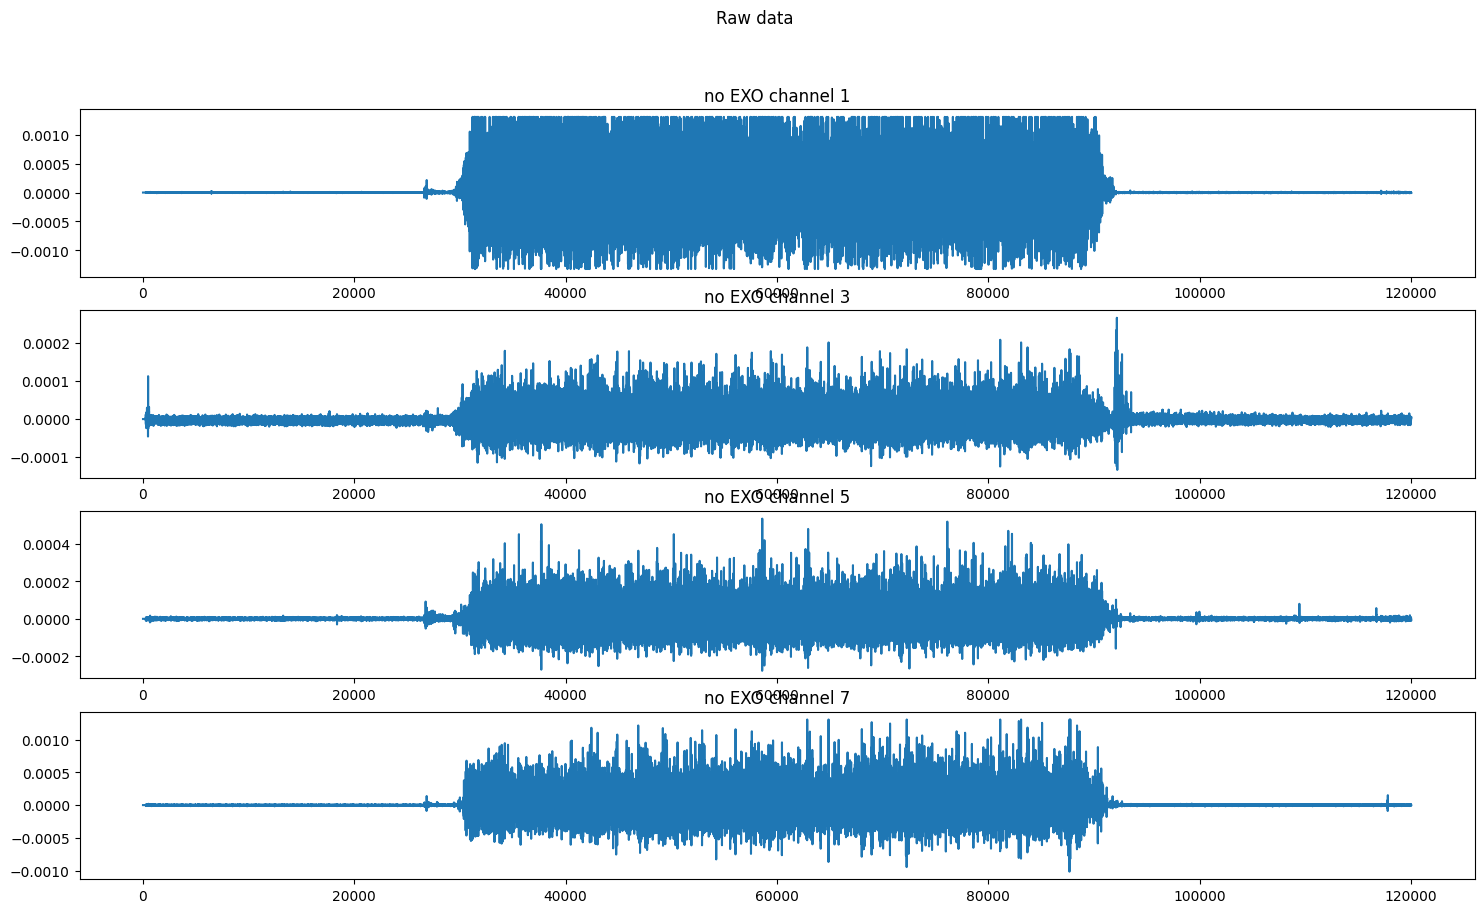

In [6]:
fig, axs = plt.subplots(4,1)
fig.suptitle('Raw data')
for i, (key, value) in enumerate(exp_noEXO_data["raw_data"].items()):
    print(i)
    axs[i].plot(np.array(value)[:,0], np.array(value)[:,1])
    axs[i].set_title(f'no EXO channel {key}')
# for i, (key, value) in enumerate(exp_EXO_data["raw_data"].items()):
#     axs[1,i].plot(np.array(value)[:,0], np.array(value)[:,1])
#     axs[1,i].set_title(f'EXO channel {key}')



fig.set_size_inches(18, 10)
fig.show()


In [7]:
def filtering(data: defaultdict) -> defaultdict:
    filtered_data = dict()
    Sampling_frequency = 1000
    band_lo = 20
    band_hi = 450
    Niquist_frequency = Sampling_frequency/2
    nor_band_lo = band_lo/Niquist_frequency
    nor_band_hi = band_hi/Niquist_frequency
    sos_band = signal.iirfilter(4, [ nor_band_lo, nor_band_hi],btype='band', ftype='butter', output = "sos")

    del_freq = 50
    nor_del_freq = del_freq/Niquist_frequency
    Quality = 30
    b, a = signal.iirnotch(nor_del_freq, Quality, Sampling_frequency)

    for key, value in data.items():
        signal_array = np.array(value)
        signal_array_band = signal.sosfiltfilt(sos_band , signal_array[:,1])
        filtered = signal.lfilter(b, a, signal_array_band)
        signal_array[:,1] = filtered
        filtered_data[key] = signal_array
    return filtered_data

In [8]:

exp_noEXO_data["filtered"] = filtering(exp_noEXO_data["raw_data"])
# exp_EXO_data["filtered"] = filtering(exp_EXO_data["raw_data"])

0
1
2
3


C:\Users\Jolly\AppData\Local\Temp\ipykernel_18860\3252174392.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


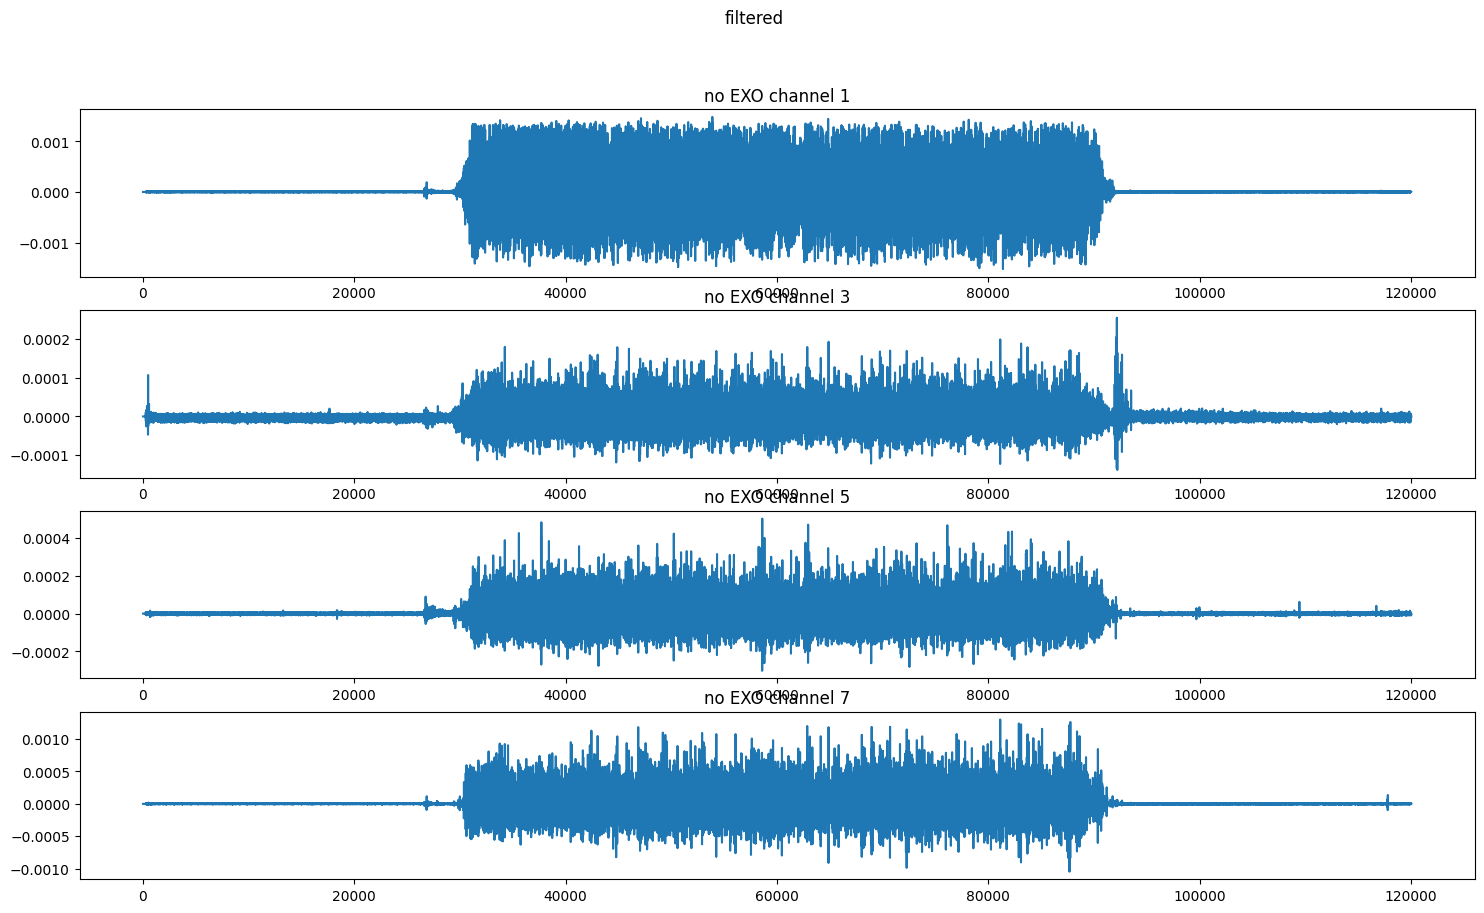

In [9]:
fig, axs = plt.subplots(4,1)
fig.suptitle('filtered')
for i, (key, value) in enumerate(exp_noEXO_data["filtered"].items()):
    print(i)
    axs[i].plot(value[:,0], value[:,1])
    axs[i].set_title(f'no EXO channel {key}')
# for i, (key, value) in enumerate(exp_EXO_data["filtered"].items()):
#     axs[1,i].plot(value[:,0], value[:,1])
#     axs[1,i].set_title(f'EXO channel {key}')



fig.set_size_inches(18, 10)
fig.show()


In [10]:
def envelope(data: dict) -> defaultdict:
    envelope_data = dict()
    window = 250
    for key, value in data.items():
        value[:,1] = np.abs(value[:,1])
        ch_data_envelope = [(i, np.max(value[int(i-window):int(i), 1])) for i in value[window::window,0]]
        envelope_data[key] = np.array(ch_data_envelope)
    return envelope_data

In [11]:
exp_noEXO_data["envelope"] = envelope(exp_noEXO_data["filtered"])
# exp_EXO_data["envelope"] = envelope(exp_EXO_data["filtered"])

In [12]:
print(exp_noEXO_data["envelope"].keys())

dict_keys(['1', '3', '5', '7'])


C:\Users\Jolly\AppData\Local\Temp\ipykernel_18860\3407360884.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


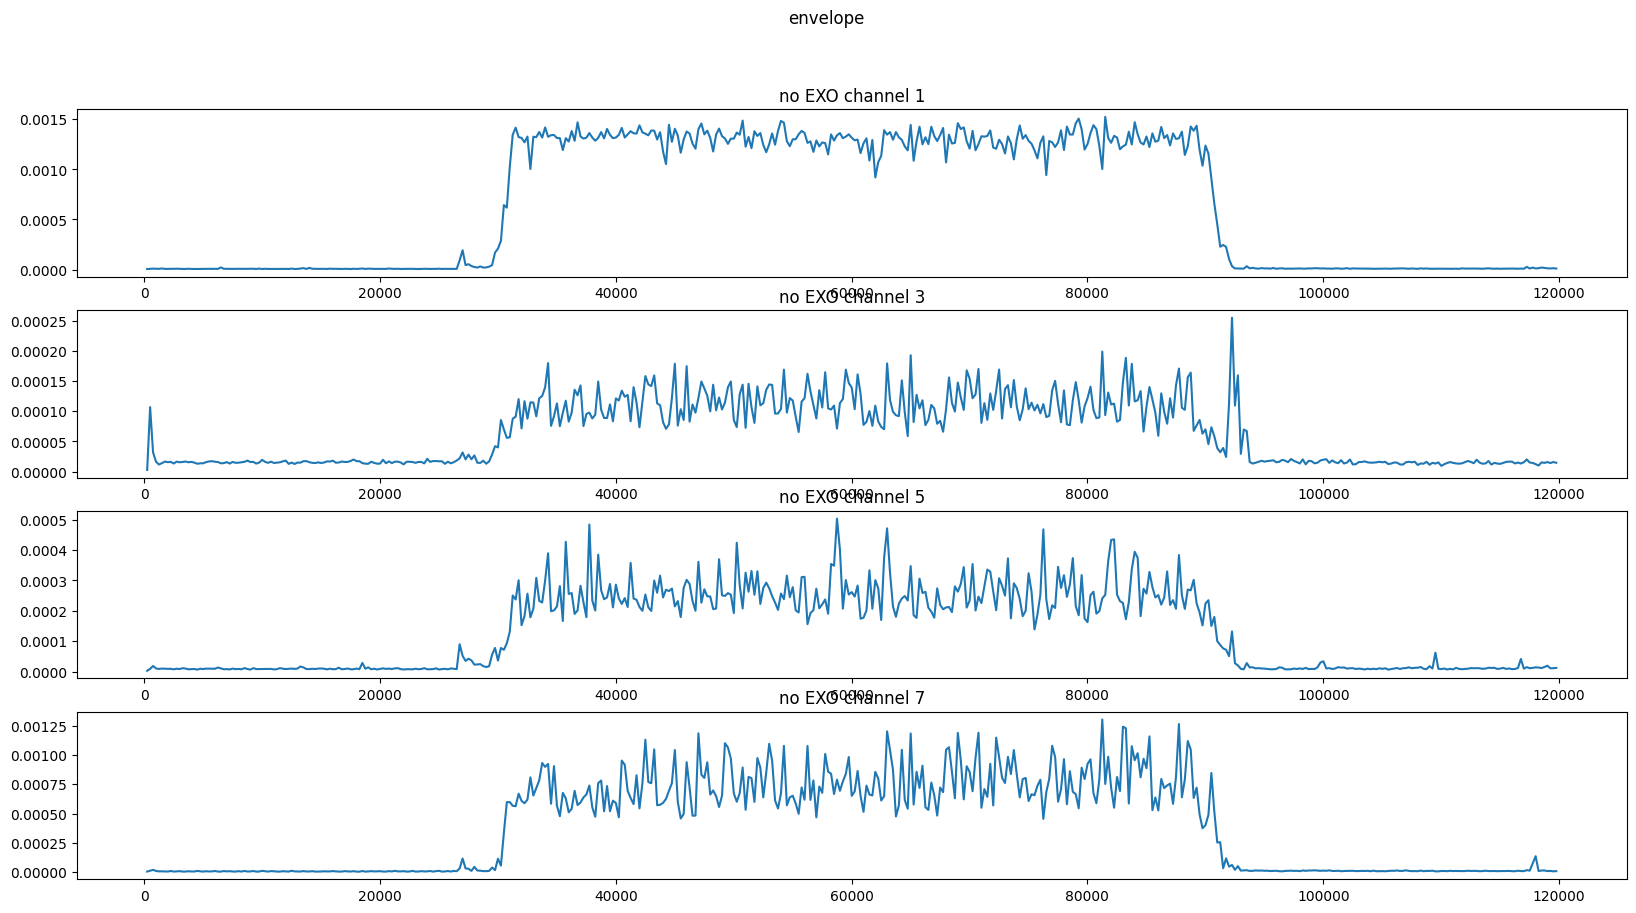

In [13]:
fig, axs = plt.subplots(4,1)
fig.suptitle('envelope')
for i, (key, value) in enumerate(exp_noEXO_data["envelope"].items()):
    axs[i].plot(value[:,0], value[:,1])
    axs[i].set_title(f'no EXO channel {key}')
# for i, (key, value) in enumerate(exp_EXO_data["envelope"].items()):
#     axs[1,i].plot(value[:,0], value[:,1])
#     axs[1,i].set_title(f'EXO channel {key}')



fig.set_size_inches(20, 10)
fig.show()


C:\Users\Jolly\AppData\Local\Temp\ipykernel_18860\3709251500.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


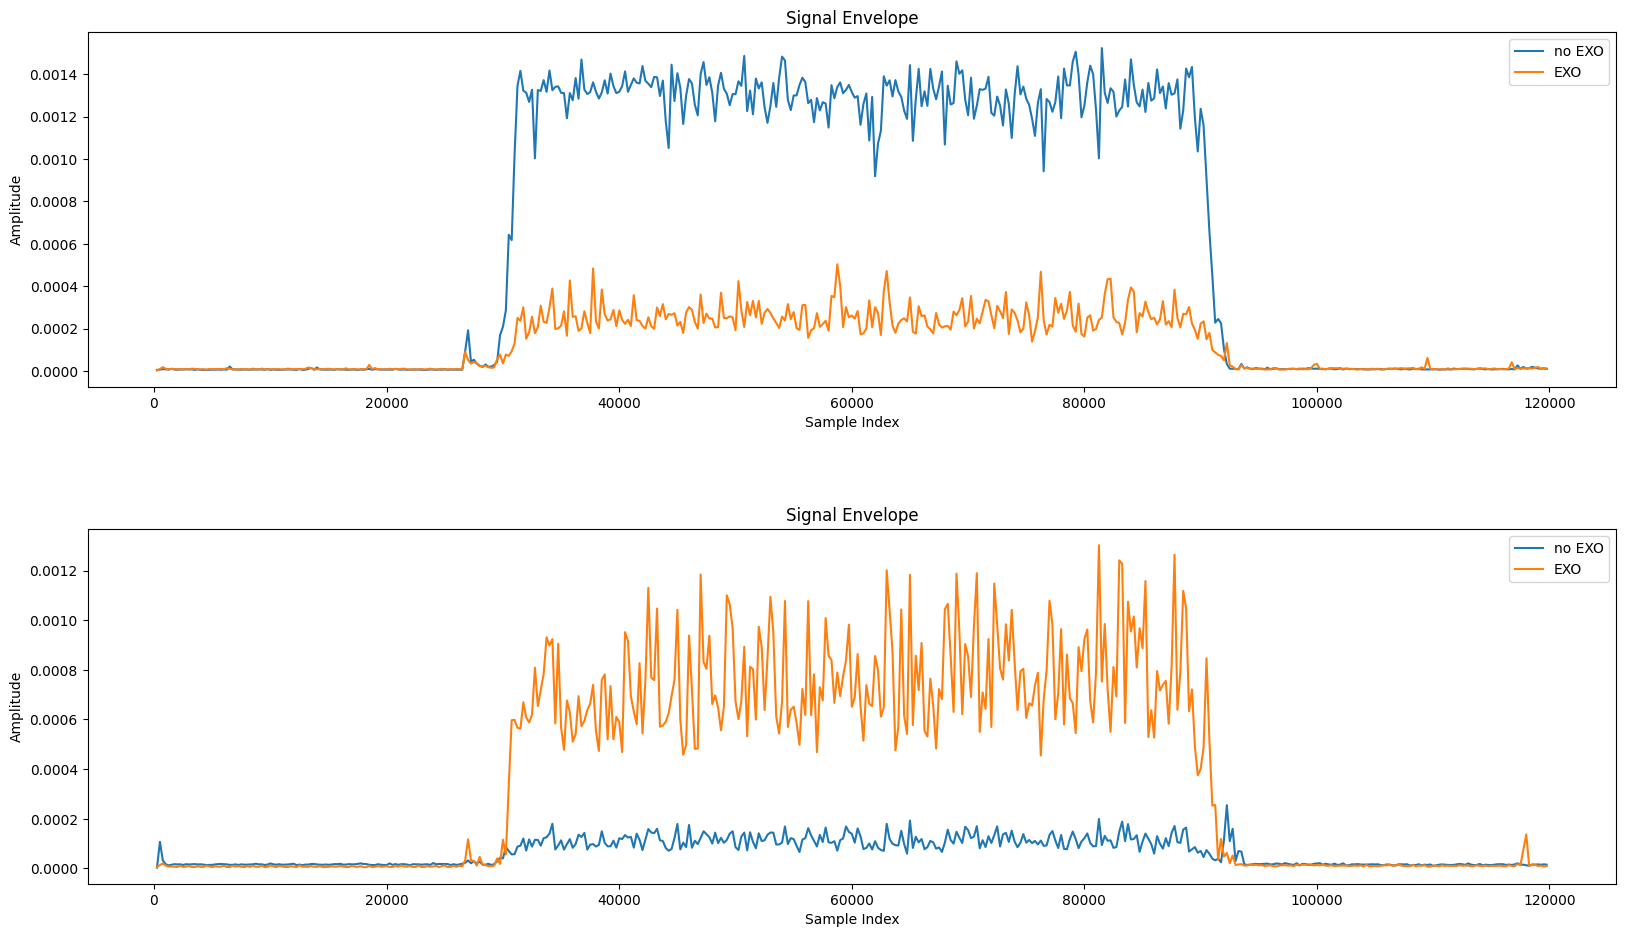

In [15]:
fig, axs = plt.subplots(2,1)
# destra affianco a destra 
axs[0].plot(exp_noEXO_data["envelope"]["1"][:,0], exp_noEXO_data["envelope"]["1"][:,1], label = "no EXO")
axs[0].plot(exp_noEXO_data["envelope"]["5"][:,0], exp_noEXO_data["envelope"]["5"][:,1], label = "EXO")
axs[0].set_title('Destro')
axs[0].legend()
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Signal Envelope')

axs[1].plot(exp_noEXO_data["envelope"]["3"][:,0], exp_noEXO_data["envelope"]["3"][:,1], label = "no EXO")
axs[1].plot(exp_noEXO_data["envelope"]["7"][:,0], exp_noEXO_data["envelope"]["7"][:,1], label = "EXO")
# axs[1].set_title('Sinistro')
axs[1].legend()
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Signal Envelope')


fig.tight_layout(pad=0.2)
fig.set_size_inches(18, 10)
fig.show()

In [45]:
exp_noEXO_data["envelope"]["6"]

array([[2.50000000e+02, 5.29046689e-06],
       [5.00000000e+02, 1.04412640e-05],
       [7.50000000e+02, 1.05617310e-05],
       ...,
       [4.19250000e+05, 4.94783630e-06],
       [4.19500000e+05, 5.03186767e-06],
       [4.19750000e+05, 1.00030222e-05]])

In [23]:
db = mGClient['experiments']

collection = db['livedata']
#estrazione dati dal db
cursor = collection.find({"experimentId": "664765192067e22ac8ea9e64"})

In [30]:
dataRMS = []
freq1 = []
freq2 = []
for x in cursor:
    try:

        dataRMS.append((x["btsData"]['data'][0]["rms"], x["btsData"]['data'][1]["rms"]))
        freq1.append((x["btsData"]["meanMedianFrequency"]["1"][0], x["btsData"]["meanMedianFrequency"]["1"][1], x["btsData"]["meanMedianFrequency"]["1"][2]))
        freq2.append((x["btsData"]["data"][0]['effort'], x["btsData"]["data"][1]['effort'], x["btsData"]["data"][1]['effort']   ))
    except:
        freq1.append((100,100,100))
        freq2.append((100,100,100))

In [31]:
len(dataRMS)

0

IndexError: index 1 is out of bounds for axis 0 with size 0

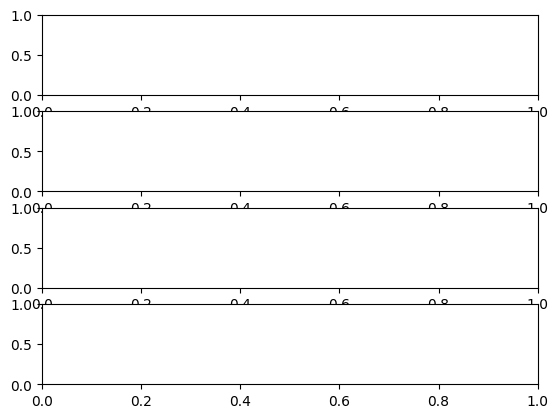

: 

In [35]:
fig, axs = plt.subplots(4,1)
# destra affianco a destra
axs[0].plot(np.array(dataRMS)[1], label = "dx")
axs[0].plot(np.array(dataRMS)[0], label = "s")
axs[0].set_title('Destro')
axs[0].legend()
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('rms')

axs[1].plot(np.array(freq1)[0], label = "dx")
axs[1].plot(np.array(freq2)[0], label = "s")
# axs[1].set_title('Sinistro')
axs[1].legend()
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('  meanMedianFrequency0')

axs[2].plot(np.array(freq1)[:,1], label = "dx")
axs[2].plot(np.array(freq2)[:,1], label = "s")
# axs[1].set_title('Sinistro')
axs[2].legend()
axs[2].set_xlabel('Sample Index')
axs[2].set_ylabel('Amplitude')
axs[2].set_title('  meanMedianFrequency1')

axs[3].plot(np.array(freq1)[:,2], label = "dx")
axs[3].plot(np.array(freq2)[:,2], label = "s")
# axs[1].set_title('Sinistro')
axs[3].legend()
axs[3].set_xlabel('Sample Index')
axs[3].set_ylabel('Amplitude')
axs[3].set_title('  meanMedianFrequency2')


fig.tight_layout(pad=0.2)
fig.set_size_inches(18, 10)
fig.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

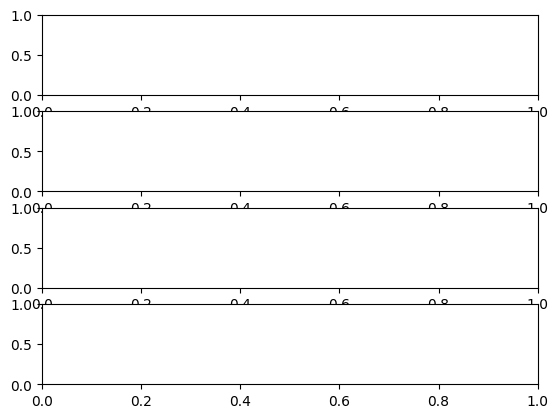

In [34]:
fig, axs = plt.subplots(4,1)
dataRMS2 = dataRMS[200:]
freq12 = freq1[200:]
freq22 = freq2[200:]
# destra affianco a destra
axs[0].plot(np.array(dataRMS2)[:,1], label = "dx")
axs[0].plot(np.array(dataRMS2)[:,0], label = "s")
axs[0].set_title('Destro')
axs[0].legend()
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('rms')

axs[1].plot(np.array(freq12)[0], label = "dx")
axs[1].plot(np.array(freq22)[0], label = "s")
# axs[1].set_title('Sinistro')
axs[1].legend()
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('  meanMedianFrequency0')

axs[2].plot(np.array(freq12)[:,1], label = "dx")
axs[2].plot(np.array(freq22)[:,1], label = "s")
# axs[1].set_title('Sinistro')
axs[2].legend()
axs[2].set_xlabel('Sample Index')
axs[2].set_ylabel('Amplitude')
axs[2].set_title('  meanMedianFrequency1')

axs[3].plot(np.array(freq12)[:,2], label = "dx")
axs[3].plot(np.array(freq22)[:,2], label = "s")
# axs[1].set_title('Sinistro')
axs[3].legend()
axs[3].set_xlabel('Sample Index')
axs[3].set_ylabel('Amplitude')
axs[3].set_title('  meanMedianFrequency2')


fig.tight_layout(pad=0.2)
fig.set_size_inches(18, 10)
fig.show()